In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

from data.CRSPLoader import CRSPLoader
from loss_functions.SharpeLoss import SharpeLoss
from models.TGNNPO import TGNNPO

plt.rcParams['figure.dpi'] = 150

In [2]:
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

In [3]:
device = torch.device('cpu')
window_length = 50
step_length = 1
etf_tickers = ['SPY', 'XLF', 'XLB', 'XLK', 'XLV', 'XLI', 'XLU', 'XLY', 'XLP', 'XLE']

# load and prepare dataset
loader = CRSPLoader(load_data=True, 
                    load_path=os.path.join(os.getcwd(), "data", "inputs"),
                    load_edge_data=True)

loader._update_ticker_index(ticker_list=etf_tickers)
dataset = loader.get_dataset(data=loader.select_tickers(tickers=etf_tickers),
                             window_length=window_length,
                             step_length=step_length)

Loading in saved CRSP data...


/Users/danieloliveira/Documents/Daniel/codes/graph-portfolio-opt/src/data/CRSPLoader.py:41: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  self._load_data(self.load_path)


Monthly Edge data only!
Generating edge weights from raw data...


Loading edge files: 100%|██████████| 245/245 [00:20<00:00, 11.84it/s]


Generating CRSP dataset...
Generating feature matrix...


100%|██████████| 5740/5740 [00:19<00:00, 293.42it/s]


Generating target matrix...


100%|██████████| 5531/5531 [00:03<00:00, 1400.69it/s]


In [9]:
steps, batch = next(iter(enumerate(dataset)))

batch

DataBatch(x=[1, 10, 985, 50], edge_index=[2, 100], y=[10, 51])

In [ ]:
# dim(batch) = (forecast_window, num_etfs, num_features, estimation_window)

In [10]:
# optimization hyperparameters
learning_rate = 0.017

# how recently should we consider our model to be "trained" by?
lookback_loss_mean = 200

# training hyperparameters
epochs = 15

Epoch: 15, sharpe (mean loss): nan: 100%|██████████| 5648/5648 [27:30<00:00,  3.42it/s]        


ValueError: All arrays must be of the same length

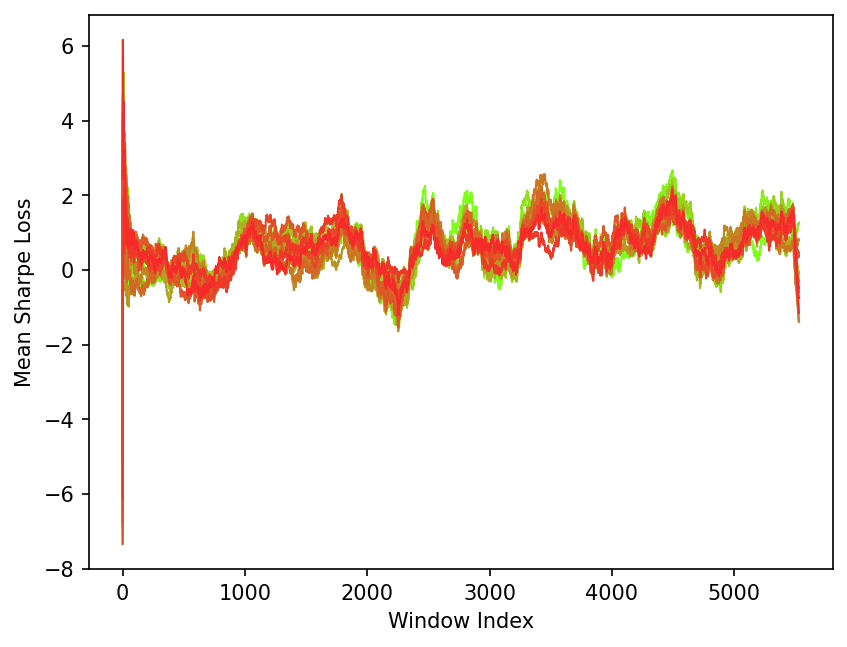

In [14]:
color_1 = '#7EFF19'
color_2 = '#F72A2A'

plt.xlabel('Window Index')
plt.ylabel('Mean Sharpe Loss')

colors = get_color_gradient(color_1, color_2, epochs)

# (1) model
model = TGNNPO(node_features=loader.num_features, periods=window_length).to(device)
model.reset_parameters()

# (2) loss function
lossfn = SharpeLoss()

# (3) training procedure
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0, maximize=True)

for epoch in range(epochs):
    # optimizer resets itself between epochs
    cur_max_lr = learning_rate
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=learning_rate/100.0, maximize=True)
    loss_history = []
    mean_history = []
    pbar = tqdm(enumerate(dataset), total=dataset.get_num_batches())
    if epoch == epochs - 1:
        results_data = {
            'date': [],
            'ticker': [],
            'returns': [],
            'weights': []
        }
    for steps, batch in pbar:
        X_batch = batch.x
        static_edge_index = batch.edge_index
        edge_weights = batch.edge_weight
        prices_batch = batch.y
        
        optimizer.zero_grad()
        
        # predict portfolio weights
        weights_pred = model(X_batch, static_edge_index, edge_weights)
  
        # sharpe ratio loss
        loss = lossfn(prices_batch[:, -2:], weights_pred, ascent=False)
        loss_history.append(loss[0].item())

        if epoch == epochs - 1:
            results_data['date'] = results_data['date'] + ([str(loader.dates[steps * step_length + window_length])[:10]] * loader.num_nodes)
            results_data['ticker'] = results_data['ticker'] + etf_tickers
            results_data['weights'] = results_data['weights'] + [weight.item() for weight in weights_pred.flatten()]
            portfolio_returns = torch.mul(weights_pred, torch.diff(torch.log(prices_batch[:, -2:]), dim=1))
            results_data['returns'] = results_data['returns'] + [return_val.item() for return_val in portfolio_returns.flatten()]

        if len(loss_history) < lookback_loss_mean:
            cur_mean_hist_val = sum(loss_history) / len(loss_history)
        else:
            cur_mean_hist_val = sum(loss_history[(-1 * lookback_loss_mean):]) / len(loss_history[(-1 * lookback_loss_mean):])
        cur_mean_hist_val = cur_mean_hist_val * np.sqrt(252)
        mean_history.append(cur_mean_hist_val)
        pbar.set_description("Epoch: %d, sharpe (mean loss): %1.5f" % (epoch + 1, mean_history[-1]))
        
        #if len(mean_history) > 1 and  mean_history[-2] - mean_history[-1] > 0.05:
        #    for g in optimizer.param_groups:
        #        g['lr'] = cur_max_lr

        loss[0].backward()
        #print(len(list(model.parameters())))
        #print(list(model.parameters())[1].grad)
        optimizer.step()
    plt.plot(list(range(dataset.get_num_batches())), mean_history, linewidth=1, label=f'Epoch {epoch+1}', color=colors[epoch])
    #learning_rate = learning_rate / 1.2

results_data = pd.DataFrame(results_data)
plt.legend()

In [23]:
import os

# Put your notebook path here
cur_notebook_path = "/Users/dylansandfelder/Documents/Work/DanielCollab/graph-portfolio-opt/src/TGNNPODraft_CRSP.ipynb"

extra_info = 1
results_csv_path = os.path.join(os.path.dirname(cur_notebook_path), f"GNN_results_{extra_info}.csv")
results_data.to_csv(results_csv_path)